In [1]:
# Imports
import os
import tarfile
from urllib.request import urlretrieve
import scipy.io
import pandas as pd

random_seed = 42

# Define URLs for dataset and labels
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

# Download dataset and labels
print("Downloading dataset...")
dataset_filename = dataset_url.split('/')[-1]
urlretrieve(dataset_url, dataset_filename)

print("Downloading labels...")
labels_filename = labels_url.split('/')[-1]
urlretrieve(labels_url, labels_filename)

# Extract dataset
print("Extracting dataset...")
with tarfile.open(dataset_filename, 'r:gz') as tar:
    tar.extractall('.')  # Extract files into the current directory

# Load labels
print("Loading labels...")
labels_data = scipy.io.loadmat(labels_filename)
labels_series = pd.Series(labels_data['labels'][0])

# Count unique classes
unique_classes = labels_series.nunique()
print(f"Number of unique classes: {unique_classes}")

# Prepare DataFrame for ImageDataGenerator
data_dir = '/kaggle/working/jpg'

# Generate DataFrame for filedata_dir names and labels
df = pd.DataFrame({
    "filename": sorted(os.listdir(data_dir)),
    "class": labels_series.astype(str)
})
print("Sample data:")
df.head()





Extracting dataset...
Loading labels...
Number of unique classes: 102
Sample data:


,filename,class
0,image_00001.jpg,77
1,image_00002.jpg,77
2,image_00003.jpg,77
3,image_00004.jpg,77
4,image_00005.jpg,77


In [ ]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19, vgg19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Configuration
epochs = 5
batch_size = 32
input_shape = (224, 224)

# Prepare dataset splits
train_df, val_test_df = train_test_split(df, stratify=df['class'], test_size=0.5, random_state=random_seed, shuffle=True)
val_df, test_df = train_test_split(val_test_df, stratify=val_test_df['class'], test_size=0.5, random_state=random_seed, shuffle=True)

# Data generators
datagen = ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)

print("Training set:")
train_gen = datagen.flow_from_dataframe(train_df, directory=data_dir, x_col='filename', y_col='class',
                                        target_size=input_shape, batch_size=batch_size, class_mode="categorical",
                                        shuffle=True, seed=random_seed)
print("Validation set:")
val_gen = datagen.flow_from_dataframe(val_df, directory=data_dir, x_col='filename', y_col='class',
                                      target_size=input_shape, batch_size=batch_size, class_mode="categorical",
                                      shuffle=False, seed=random_seed)
print("Test set:")
test_gen = datagen.flow_from_dataframe(test_df, directory=data_dir, x_col='filename', y_col='class',
                                       target_size=input_shape, batch_size=batch_size, class_mode="categorical",
                                       shuffle=False, seed=random_seed)


In [6]:
vgg_base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg_base_model.summary()
vgg_base_model.trainable = False  # Freeze the base model

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training and evaluation with a fresh model for each cycle
test_results = {'Accuracy': [], 'Loss': []}
histories = []

for i in range(2):  # Repeat the training-evaluation cycle twice
    print(f"\nTraining-Evaluation cycle - {i + 1}")

    # Create a fresh model for each cycle
    vgg_base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    vgg_base_model.trainable = False  # Freeze the base model
    n_classes = len(df['class'].unique())
    
    model = Sequential([
        vgg_base_model,
        GlobalAveragePooling2D(),
        Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='RMSprop', loss="categorical_crossentropy", metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

    # Training
    history = model.fit(train_gen, epochs=epochs, callbacks=[early_stopping],
                        validation_data=val_gen, verbose=1)
    histories.append(history)

    # Evaluation
    loss, accuracy = model.evaluate(test_gen)
    test_results['Accuracy'].append(accuracy)
    test_results['Loss'].append(loss)

    print("Test Loss:", round(loss, 3))
    print(f"Test Accuracy: {round(accuracy * 100, 3)}%")

# Summarize results
avg_accuracy = np.mean(test_results["Accuracy"])
avg_loss = np.mean(test_results["Loss"])
print(f"\nFinal Test Results - Avg Accuracy: {round(avg_accuracy * 100, 3)}%, Avg Loss: {round(avg_loss, 3)}")



Training-Evaluation cycle - 1

Training:
Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.0936 - loss: 7.9849 - val_accuracy: 0.4191 - val_loss: 2.6886
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.5477 - loss: 1.8737 - val_accuracy: 0.6488 - val_loss: 1.4560
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.7951 - loss: 0.7795 - val_accuracy: 0.7396 - val_loss: 1.0481
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.8925 - loss: 0.3992 - val_accuracy: 0.7738 - val_loss: 0.8873
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9293 - loss: 0.2677 - val_accuracy: 0.8056 - val_loss: 0.7890

Evaluating:
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8035 - loss: 0.7769
Test Loss: 0.782
Test Accuracy: 80.176%

Training-Evaluation cycle - 2

Training:
Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.1182 - loss: 7.1418 - val_accuracy: 0.4573 - val_loss: 2.4687
Epoch 2/5

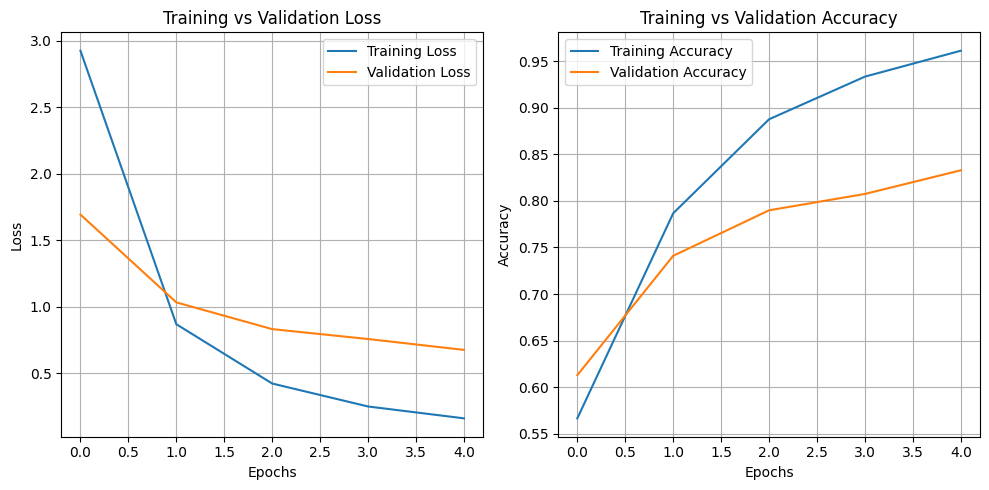

In [4]:
# Plot training and validation metrics with X, Y explanations
avg_loss = [np.mean([h.history['loss'][epoch] for h in histories if epoch < len(h.history['loss'])]) for epoch in range(epochs)]
avg_val_loss = [np.mean([h.history['val_loss'][epoch] for h in histories if epoch < len(h.history['val_loss'])]) for epoch in range(epochs)]
avg_accuracy = [np.mean([h.history['accuracy'][epoch] for h in histories if epoch < len(h.history['accuracy'])]) for epoch in range(epochs)]
avg_val_accuracy = [np.mean([h.history['val_accuracy'][epoch] for h in histories if epoch < len(h.history['val_accuracy'])]) for epoch in range(epochs)]

plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(avg_loss, label="Training Loss")
plt.plot(avg_val_loss, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(avg_accuracy, label="Training Accuracy")
plt.plot(avg_val_accuracy, label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()
